In [1]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import pickle
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import gc
import time
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.regularizers import l1,l2
from tqdm import tqdm
import heapq
from sklearn.utils import shuffle
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, RMSprop
import bert


Populating the interactive namespace from numpy and matplotlib


C:\Users\dhirajsrivastava\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


           Review from here  

In [2]:
with open('train_image_dict.pickle', 'rb') as handle:
    all_image_dict = pickle.load(handle)

In [3]:
with open('val_image_dict.pickle', 'rb') as handle:
    val_image_dict = pickle.load(handle)

In [4]:
# Get keys
oldkeys = list(all_image_dict.keys())
# Change "item" to "object"
newkeys = [s.replace('Train', 'train2014/train2014') for s in oldkeys]
# Get values
vals = list(all_image_dict.values())
# Create new dictionary by iterating over both newkeys and vals
all_image_dict = {k: v for k, v in zip(newkeys, vals)}

In [5]:
# Get keys
oldkeys = list(val_image_dict.keys())
# Change "item" to "object"
newkeys = [s.replace('Val', 'val2014/val2014') for s in oldkeys]
# Get values
vals = list(val_image_dict.values())
# Create new dictionary by iterating over both newkeys and vals
val_image_dict = {k: v for k, v in zip(newkeys, vals)}

In [6]:
all_image_dict.update(val_image_dict)

In [7]:
train_images = 'train2014/train2014'
val_images = 'val2014/val2014'

In [8]:
training_questions = 'v2_Questions_Train_mscoco/v2_OpenEnded_mscoco_train2014_questions.json'
validation_questions = 'v2_Questions_Val_mscoco/v2_OpenEnded_mscoco_val2014_questions.json'

In [9]:
with open(training_questions, 'r') as f:
    train_questions = json.load(f)



with open(validation_questions, 'r') as f:
    val_questions = json.load(f)


In [10]:
training_annotations = 'v2_Annotations_Train_mscoco/v2_mscoco_train2014_annotations.json'
validation_annotations = 'v2_Annotations_Val_mscoco/v2_mscoco_val2014_annotations.json'

In [11]:
with open(training_annotations, 'r') as f:
    train_annotations = json.load(f)
    
    
with open(validation_annotations, 'r') as f:
    val_annotations = json.load(f)

In [12]:
train_questions_df = pd.DataFrame(train_questions['questions'])
val_questions_df = pd.DataFrame(val_questions['questions'])

In [13]:
train_annotations_df = pd.DataFrame(train_annotations['annotations'])
val_annotations_df = pd.DataFrame(val_annotations['annotations'])

In [14]:
train_data = pd.merge(train_questions_df,train_annotations_df,  how='inner', left_on=['image_id','question_id'], right_on = ['image_id','question_id'])
val_data = pd.merge(val_questions_df,val_annotations_df,  how='inner', left_on=['image_id','question_id'], right_on = ['image_id','question_id'])

In [15]:
def persons_answers(answers):
    answers_dict = {}
    score_dict = { 'yes' : 3, 'maybe' : 2, 'no' : 1 }
    for _answer in answers:
        score = score_dict[_answer['answer_confidence']]
        if answers_dict.get(_answer['answer'],-1) != -1 :
            answers_dict[_answer['answer']] += score
        else:
            answers_dict[_answer['answer']] = score

    return sorted(list(answers_dict.items()),key = lambda x: x[1],reverse=True)[0][0]

In [16]:
train_data['derived_answer'] =  train_data["answers"].apply(lambda x: persons_answers(x))
val_data['derived_answer'] =  val_data["answers"].apply(lambda x: persons_answers(x))

In [17]:
X_train = train_data
X_val = val_data

In [18]:
img_width = 448 
img_height = 448

BATCH_SIZE = 64
BUFFER_SIZE = 300

In [19]:
X_train.dropna(inplace=True)
X_val.dropna(inplace=True)

In [20]:
contractions = { 
"ain't": "am not","aren't": "are not","can't": "cannot","can't've": "cannot have","'cause": "because","could've": "could have","couldn't": "could not",
"couldn't've": "could not have","didn't": "did not","doesn't": "does not","don't": "do not","hadn't": "had not","hadn't've": "had not have",
"hasn't": "has not","haven't": "have not","he'd": "he would","he'd've": "he would have","he'll": "he will","he's": "he is","how'd": "how did",
"how'll": "how will","how's": "how is","i'd": "i would","i'll": "i will","i'm": "i am","i've": "i have","isn't": "is not","it'd": "it would",
"it'll": "it will","it's": "it is","let's": "let us","ma'am": "madam","mayn't": "may not","might've": "might have","mightn't": "might not",
"must've": "must have","mustn't": "must not","needn't": "need not","oughtn't": "ought not","shan't": "shall not","sha'n't": "shall not","she'd": "she would",
"she'll": "she will","she's": "she is","should've": "should have","shouldn't": "should not","that'd": "that would","that's": "that is","there'd": "there had",
"there's": "there is","they'd": "they would","they'll": "they will","they're": "they are","they've": "they have","wasn't": "was not","we'd": "we would",
"we'll": "we will","we're": "we are","we've": "we have","weren't": "were not","what'll": "what will","what're": "what are","what's": "what is",
"what've": "what have","where'd": "where did","where's": "where is","who'll": "who will","who's": "who is","won't": "will not","wouldn't": "would not",
"you'd": "you would","you'll": "you will","you're": "you are"
}

def preprocess_text(text):
    '''Given a text this function removes the punctuations and returns the remaining text string'''
    new_text = ""
    text = text.lower()
    i = 0
    for word in text.split():
        if i==0:
            new_text = contractions.get(word,word)
        else:
            new_text = new_text + " " + contractions.get(word,word)
        i += 1
    return new_text.replace("'s", '')

In [21]:
X_train['multiple_choice_answer'] = X_train['multiple_choice_answer'].apply(lambda x: preprocess_text(x))
X_val['multiple_choice_answer'] = X_val['multiple_choice_answer'].apply(lambda x: preprocess_text(x))

In [22]:
len(X_train), len(X_val)

(443757, 214354)

In [23]:
all_classes = X_train['multiple_choice_answer'].values
class_frequency = {}

for _cls in all_classes:
    if(class_frequency.get(_cls,-1)>0):
        class_frequency[_cls] += 1
    else:
        class_frequency[_cls] = 1

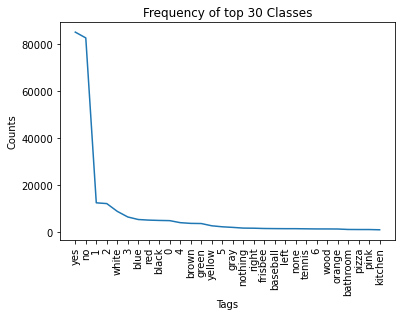

In [24]:
sort_class_frequency = sorted(list(class_frequency.items()), key = lambda x: x[1],reverse=True)   

plt.plot([x[1] for x in sort_class_frequency[:30]])
i=np.arange(30)
plt.title("Frequency of top 30 Classes")
plt.xlabel("Tags")
plt.ylabel("Counts")
plt.xticks(i,[x[0] for x in sort_class_frequency[:30]])
plt.xticks(rotation=90)
plt.show()

In [25]:
common_tags = heapq.nlargest(1000, class_frequency, key = class_frequency.get)

In [26]:
# take the top 1000 classes
X_train['multiple_choice_answer'] =  X_train['multiple_choice_answer'].apply(lambda x: x if x in common_tags else '')

# removing question which has empty tags
X_train = X_train[X_train['multiple_choice_answer'].apply(lambda x: len(x)>0)]

In [27]:
label_encoder = LabelBinarizer()
answer_vector_train = label_encoder.fit_transform(X_train['multiple_choice_answer'].apply(lambda x: x).values)
answer_vector_val = label_encoder.fit_transform(X_val['multiple_choice_answer'].apply(lambda x: x).values)

ans_vocab = {l: i for i, l in enumerate(label_encoder.classes_)}

print("Number of clasess: ", len(ans_vocab))
print("Shape of Answer Vectors in Train Data: ", answer_vector_train.shape)
print("Shape of Answer Vectors in Validation Data: ", answer_vector_val.shape)

Number of clasess:  13969
Shape of Answer Vectors in Train Data:  (388252, 1000)
Shape of Answer Vectors in Validation Data:  (214354, 13969)


In [28]:
def preprocess_question(text):
    '''Given a text this function removes the punctuations and returns the remaining text string'''
    new_text = "<start>"
    text = text.lower()
    for word in text.split():
        new_text = new_text + " " + contractions.get(word, word)
    new_text = new_text + " <end>"
    return new_text.replace("'s", '')

In [29]:
X_train['question'] = X_train['question'].apply(lambda x: preprocess_question(x))
X_val['question'] = X_val['question'].apply(lambda x: preprocess_question(x))

<ipython-input-29-c9f73ee18296>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['question'] = X_train['question'].apply(lambda x: preprocess_question(x))


In [30]:
#tokenization
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token = "<unk>", filters = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(X_train['question'].values)
train_question_seqs = tokenizer.texts_to_sequences(X_train['question'].values)
val_question_seqs = tokenizer.texts_to_sequences(X_val['question'].values)

print("Number of words in tokenizer:", len(tokenizer.word_index))
ques_vocab = tokenizer.word_index

#Padding
#tokenizer.word_index['<pad>'] = 0
#tokenizer.index_word[0] = '<pad>'
question_vector_train = tf.keras.preprocessing.sequence.pad_sequences(train_question_seqs, padding='post')
question_vector_val = tf.keras.preprocessing.sequence.pad_sequences(val_question_seqs,padding='post',maxlen=question_vector_train.shape[1])

print("Shape of Question Vectors in Train Data: ", question_vector_train.shape)
print("Shape of Question Vectors in Validation Data: ", question_vector_val.shape)

Number of words in tokenizer: 12450
Shape of Question Vectors in Train Data:  (388252, 24)
Shape of Question Vectors in Validation Data:  (214354, 24)


In [31]:
image_paths_train = X_train['image_id'].apply(lambda x:  train_images + '/COCO_train2014_' + '%012d.jpg' % (x)).values
image_paths_val = X_val['image_id'].apply(lambda x:  val_images + '/COCO_val2014_' + '%012d.jpg' % (x)).values


In [32]:
def get_imageTensor(img, ques):
    #path = img.decode('utf-8').replace(imageDirectory,imageNumpyDirectory).replace('.jpg',"") +'.npy'
    #img_tensor = np.load(path)
    img_tensor = all_image_dict[img.decode('utf-8')]
    img_tensor = tf.squeeze(img_tensor)
#     print('img : ' + str(img_tensor.shape))
    return img_tensor, ques

def createDataset(image_paths, question_vector, answer_vector):
    dataset_input = tf.data.Dataset.from_tensor_slices((image_paths, question_vector.astype(np.float32)))
    dataset_output = tf.data.Dataset.from_tensor_slices((answer_vector.astype(np.float32)))
    
    # using map to load the numpy files in parallel
    dataset_input = dataset_input.map(lambda img, ques : tf.numpy_function(get_imageTensor, [img, ques], [tf.float32, tf.float32]),
                                      num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # shuffling and batching
    #dataset_input = dataset_input.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    dataset_input = dataset_input.batch(BATCH_SIZE)
    dataset_output = dataset_output.batch(BATCH_SIZE)#.repeat()
    
    dataset = tf.data.Dataset.zip((dataset_input, dataset_output))
    dataset = dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

    return dataset

In [33]:
question_vector_train.shape, image_paths_train.shape, answer_vector_train.shape

((388252, 24), (388252,), (388252, 1000))

In [34]:
question_vector_val.shape, image_paths_val.shape, answer_vector_val.shape

((214354, 24), (214354,), (214354, 13969))

In [35]:
dataset_train = createDataset(image_paths_train, question_vector_train, answer_vector_train)
dataset_val = createDataset(image_paths_val, question_vector_val, answer_vector_val)

In [36]:
dataset_train

<PrefetchDataset shapes: ((<unknown>, <unknown>), (None, 1000)), types: ((tf.float32, tf.float32), tf.float32)>

In [37]:
list(all_image_dict.values())[0].shape

(1, 14, 14, 512)

In [38]:
class CoattentionModel(tf.keras.layers.Layer):
    def __init__(self):#, num_embeddings, num_classes, embed_dim=512, k=30
        super().__init__()
        self.num_classes = len(ans_vocab)
        self.hidden_size = 512
        self.dropout = 0.3
        self.num_embeddings = len(ques_vocab)+1

        self.image_dense = tf.keras.layers.Dense(self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_normal(seed=15)) 
        self.image_corr = tf.keras.layers.Dense(self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_normal(seed=29))

        self.image_atten_dense = tf.keras.layers.Dense(self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=17)) 
        self.question_atten_dens = tf.keras.layers.Dense(self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=28))
        self.question_atten_dropout = tf.keras.layers.Dropout(self.dropout)
        self.image_atten_dropout = tf.keras.layers.Dropout(self.dropout)

        self.ques_atten = tf.keras.layers.Dense(1, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=21))

        self.img_atten = tf.keras.layers.Dense(1, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=33))

        self.embed = tf.keras.layers.Embedding(self.num_embeddings, self.hidden_size,
                                               embeddings_initializer = tf.keras.initializers.RandomNormal(mean=0, stddev=1, seed=23))
        
        self.unigram_conv = tf.keras.layers.Conv1D(filters = self.hidden_size, kernel_size = 1, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed=41))
        self.bigram_conv  = tf.keras.layers.Conv1D(filters = self.hidden_size, kernel_size = 2, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed=58), dilation_rate = 2)
        self.trigram_conv = tf.keras.layers.Conv1D(filters = self.hidden_size, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed=89), dilation_rate = 2)
        self.max_pool = tf.keras.layers.MaxPool2D((3,1))
        self.phrase_dropout = tf.keras.layers.Dropout(self.dropout)
        
        self.lstm = tf.keras.layers.LSTM(units = 512 , return_sequences=True, dropout = self.dropout,
                                         kernel_initializer = tf.keras.initializers.glorot_uniform(seed=26),
                                         recurrent_initializer = tf.keras.initializers.orthogonal(seed=54))
        
        self.tanh = tf.keras.layers.Activation('tanh')
        self.softmax = tf.keras.layers.Activation('softmax')
        
        self.W_w_dropout = tf.keras.layers.Dropout(self.dropout)
        self.W_p_dropout = tf.keras.layers.Dropout(self.dropout)
        self.W_s_dropout = tf.keras.layers.Dropout(self.dropout)

        self.W_w = tf.keras.layers.Dense(units = self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=32), input_shape = (self.hidden_size,))
        self.W_p = tf.keras.layers.Dense(units = self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=49), input_shape = (2 * self.hidden_size, ))
        self.W_s = tf.keras.layers.Dense(units = self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=31), input_shape = (2 * self.hidden_size, ))
        
        self.fc1_Dense = tf.keras.layers.Dense(units = 2 * self.hidden_size, activation='relu',
                                               kernel_initializer = tf.keras.initializers.he_normal(seed=84))
        self.fc1_dropout = tf.keras.layers.Dropout(self.dropout)

        self.fc = tf.keras.layers.Dense(units = self.num_classes, activation='softmax',kernel_initializer = tf.keras.initializers.glorot_uniform(seed=91), input_shape = (self.hidden_size,))
        
        return

    def call(self, image, question):#Image: B x 196 x 512
        
        image = self.image_dense(image)
        image = self.tanh(image)

        words = self.embed(question)    # Words: B x L x 51

        unigrams =  tf.expand_dims(self.tanh(self.unigram_conv(words)), 1) # B x L x 512
        bigrams  =  tf.expand_dims(self.tanh(self.bigram_conv(words)), 1)  # B x L x 512
        trigrams =  tf.expand_dims(self.tanh(self.trigram_conv(words)), 1) # B x L x 512

        phrase = tf.squeeze(self.max_pool(tf.concat((unigrams, bigrams, trigrams), 1)), axis=1)  # B x L x 512
        phrase = self.tanh(phrase)
        phrase = self.phrase_dropout(phrase)
  
        hidden = None
        sentence = self.lstm(phrase)        # B x L x 512   

        print(words.shape, phrase.shape, sentence.shape)
        v_word, q_word = self.co_attention(image, words)
        v_phrase, q_phrase = self.co_attention(image, phrase)
        v_sent, q_sent = self.co_attention(image, sentence)

        h_w = self.tanh(self.W_w(self.W_w_dropout(q_word + v_word)))
        h_p = self.tanh(self.W_p(self.W_p_dropout(tf.concat(((q_phrase + v_phrase), h_w), axis=1))))
        h_s = self.tanh(self.W_s(self.W_s_dropout(tf.concat(((q_sent + v_sent), h_p), axis=1))))

        fc1 = self.fc1_Dense(self.fc1_dropout(h_s))
        logits = self.fc(fc1)

        return logits

    def co_attention(self, img_feat, ques_feat):  # V : B x 512 x 196, Q : B x L x 512
        img_corr = self.image_corr(img_feat)

        weight_matrix = tf.keras.backend.batch_dot(ques_feat, img_corr, axes = (2, 2))
        weight_matrix = self.tanh(weight_matrix)

        ques_embed = self.image_atten_dense(ques_feat)
        img_embed = self.question_atten_dens(img_feat)

        transform_img = tf.keras.backend.batch_dot(weight_matrix, img_embed)

        ques_atten_sum = self.tanh(transform_img + ques_embed)
        ques_atten_sum = self.question_atten_dropout(ques_atten_sum)
        ques_atten = self.ques_atten(ques_atten_sum)
        ques_atten =  tf.keras.layers.Reshape((ques_atten.shape[1],))(ques_atten)
        ques_atten =  self.softmax(ques_atten)

        transform_ques = tf.keras.backend.batch_dot(weight_matrix, ques_embed, axes = (1, 1))
        img_atten_sum = self.tanh(transform_ques+img_embed)
        img_atten_sum = self.image_atten_dropout(img_atten_sum)
        img_atten = self.img_atten(img_atten_sum)
        img_atten = tf.keras.layers.Reshape((img_atten.shape[1],))(img_atten)
        img_atten = self.softmax(img_atten)

        ques_atten = tf.keras.layers.Reshape(( 1, ques_atten.shape[1]))(ques_atten)
        img_atten = tf.keras.layers.Reshape(( 1, img_atten.shape[1]))(img_atten)

        ques_atten_feat = tf.keras.backend.batch_dot(ques_atten,ques_feat)
        print(ques_atten_feat)
        ques_atten_feat = tf.keras.layers.Reshape(( ques_atten_feat.shape[-1],))(ques_atten_feat)

        img_atten_feat =  tf.keras.backend.batch_dot(img_atten, img_feat)
        print(img_atten_feat)
        img_atten_feat = tf.keras.layers.Reshape((img_atten_feat.shape[-1],))(img_atten_feat)

        return img_atten_feat, ques_atten_feat

In [39]:
def scheduler(epoch):
    if epoch < 10:
        return 0.0001
    else:
        return 0.0001 * tf.math.exp(0.1 * (10 - epoch))

In [40]:
def callBacksList():
    """
    returns list of callback's
    """
    filepath = "Models" + ModelName + "/optimum.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = filepath, monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'auto')
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2)
    early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 4, verbose = 1)
    scheduler_lr = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0 )

    #directory for tensorboard to save evnts
    log_dir= "Models" + "logs/fit/" + ModelName + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    os.makedirs(log_dir)

    #print("TensorBoard Folder for this Execution",log_dir)#creating TensorBoard call back,this will write all events to given folder
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 0)

    history = tf.keras.callbacks.History()
    callbacks_list = [scheduler_lr, early_stop, history, tensorboard_callback, checkpoint]
    return callbacks_list

In [41]:
def Build_CoattentionModel():
    image_input1 = tf.keras.layers.Input(shape = (14,14, 512))
    image_input = tf.keras.layers.Reshape((-1, 512))(image_input1)

    question_input = tf.keras.layers.Input(shape=(question_vector_train.shape[1],))

    output = CoattentionModel()(image_input, question_input)#num_embeddings = len(ques_vocab), num_classes = len(ans_vocab), embed_dim = 512

    model = tf.keras.models.Model(inputs = [image_input1, question_input], outputs = output)

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [42]:
model = Build_CoattentionModel()
l2_alpha = 0.001
ModelName = 'Coattention'
history = model.fit(dataset_train, epochs = 20, steps_per_epoch=100, validation_data=dataset_val,validation_steps=100)

(None, 24, 512) (None, 24, 512) (None, 24, 512)
Tensor("coattention_model/MatMul_3:0", shape=(None, 1, 512), dtype=float32)
Tensor("coattention_model/MatMul_4:0", shape=(None, 1, 512), dtype=float32)
Tensor("coattention_model/MatMul_8:0", shape=(None, 1, 512), dtype=float32)
Tensor("coattention_model/MatMul_9:0", shape=(None, 1, 512), dtype=float32)
Tensor("coattention_model/MatMul_13:0", shape=(None, 1, 512), dtype=float32)
Tensor("coattention_model/MatMul_14:0", shape=(None, 1, 512), dtype=float32)
Epoch 1/20
(None, 24, 512) (None, 24, 512) (None, 24, 512)
Tensor("model/coattention_model/MatMul_3:0", shape=(None, 1, 512), dtype=float32)
Tensor("model/coattention_model/MatMul_4:0", shape=(None, 1, 512), dtype=float32)
Tensor("model/coattention_model/MatMul_8:0", shape=(None, 1, 512), dtype=float32)
Tensor("model/coattention_model/MatMul_9:0", shape=(None, 1, 512), dtype=float32)
Tensor("model/coattention_model/MatMul_13:0", shape=(None, 1, 512), dtype=float32)
Tensor("model/coattentio

ValueError: in user code:

    File "C:\Users\dhirajsrivastava\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\dhirajsrivastava\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\dhirajsrivastava\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\dhirajsrivastava\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 809, in train_step
        loss = self.compiled_loss(
    File "C:\Users\dhirajsrivastava\AppData\Roaming\Python\Python38\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\dhirajsrivastava\AppData\Roaming\Python\Python38\site-packages\keras\losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\dhirajsrivastava\AppData\Roaming\Python\Python38\site-packages\keras\losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\dhirajsrivastava\AppData\Roaming\Python\Python38\site-packages\keras\losses.py", line 1664, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\dhirajsrivastava\AppData\Roaming\Python\Python38\site-packages\keras\backend.py", line 4994, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1000) and (None, 13969) are incompatible


In [45]:
model = Build_CoattentionModel()
l2_alpha = 0.001
ModelName = 'Coattention'
history = model.fit(dataset_train, epochs = 20, steps_per_epoch=100, validation_data=dataset_val,validation_steps=100)

(None, 24, 512) (None, 24, 512) (None, 24, 512)
Tensor("coattention_model/MatMul_3:0", shape=(None, 1, 512), dtype=float32)
Tensor("coattention_model/MatMul_4:0", shape=(None, 1, 512), dtype=float32)
Tensor("coattention_model/MatMul_8:0", shape=(None, 1, 512), dtype=float32)
Tensor("coattention_model/MatMul_9:0", shape=(None, 1, 512), dtype=float32)
Tensor("coattention_model/MatMul_13:0", shape=(None, 1, 512), dtype=float32)
Tensor("coattention_model/MatMul_14:0", shape=(None, 1, 512), dtype=float32)
Epoch 1/20
(None, 24, 512) (None, 24, 512) (None, 24, 512)
Tensor("model/coattention_model/MatMul_3:0", shape=(None, 1, 512), dtype=float32)
Tensor("model/coattention_model/MatMul_4:0", shape=(None, 1, 512), dtype=float32)
Tensor("model/coattention_model/MatMul_8:0", shape=(None, 1, 512), dtype=float32)
Tensor("model/coattention_model/MatMul_9:0", shape=(None, 1, 512), dtype=float32)
Tensor("model/coattention_model/MatMul_13:0", shape=(None, 1, 512), dtype=float32)
Tensor("model/coattentio

In [46]:
model.save('Models/coattention.h5')

                                                                                   SGD

In [41]:
def Build_CoattentionModel():
    image_input1 = tf.keras.layers.Input(shape = (14,14, 512))
    image_input = tf.keras.layers.Reshape((-1, 512))(image_input1)

    question_input = tf.keras.layers.Input(shape=(question_vector_train.shape[1],))

    output = CoattentionModel()(image_input, question_input)#num_embeddings = len(ques_vocab), num_classes = len(ans_vocab), embed_dim = 512

    model = tf.keras.models.Model(inputs = [image_input1, question_input], outputs = output)

    model.compile(optimizer = tf.keras.optimizers.SGD(), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [42]:
model = Build_CoattentionModel()
l2_alpha = 0.001
ModelName = 'Coattention'
history = model.fit(dataset_train, epochs = 20, steps_per_epoch=100, validation_data=dataset_val,validation_steps=100)

(None, 24, 512) (None, 24, 512) (None, 24, 512)
Tensor("coattention_model/MatMul_3:0", shape=(None, 1, 512), dtype=float32)
Tensor("coattention_model/MatMul_4:0", shape=(None, 1, 512), dtype=float32)
Tensor("coattention_model/MatMul_8:0", shape=(None, 1, 512), dtype=float32)
Tensor("coattention_model/MatMul_9:0", shape=(None, 1, 512), dtype=float32)
Tensor("coattention_model/MatMul_13:0", shape=(None, 1, 512), dtype=float32)
Tensor("coattention_model/MatMul_14:0", shape=(None, 1, 512), dtype=float32)
Epoch 1/20
(None, 24, 512) (None, 24, 512) (None, 24, 512)
Tensor("model/coattention_model/MatMul_3:0", shape=(None, 1, 512), dtype=float32)
Tensor("model/coattention_model/MatMul_4:0", shape=(None, 1, 512), dtype=float32)
Tensor("model/coattention_model/MatMul_8:0", shape=(None, 1, 512), dtype=float32)
Tensor("model/coattention_model/MatMul_9:0", shape=(None, 1, 512), dtype=float32)
Tensor("model/coattention_model/MatMul_13:0", shape=(None, 1, 512), dtype=float32)
Tensor("model/coattentio

In [43]:
model.save('Models/coattention_SGD.h5')

                                     LSTM units 256, hidden size 256

In [44]:
class CoattentionModel(tf.keras.layers.Layer):
    def __init__(self):#, num_embeddings, num_classes, embed_dim=512, k=30
        super().__init__()
        self.num_classes = len(ans_vocab)
        self.hidden_size = 256
        self.dropout = 0.3
        self.num_embeddings = len(ques_vocab)+1

        self.image_dense = tf.keras.layers.Dense(self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_normal(seed=15)) 
        self.image_corr = tf.keras.layers.Dense(self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_normal(seed=29))

        self.image_atten_dense = tf.keras.layers.Dense(self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=17)) 
        self.question_atten_dens = tf.keras.layers.Dense(self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=28))
        self.question_atten_dropout = tf.keras.layers.Dropout(self.dropout)
        self.image_atten_dropout = tf.keras.layers.Dropout(self.dropout)

        self.ques_atten = tf.keras.layers.Dense(1, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=21))

        self.img_atten = tf.keras.layers.Dense(1, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=33))

        self.embed = tf.keras.layers.Embedding(self.num_embeddings, self.hidden_size,
                                               embeddings_initializer = tf.keras.initializers.RandomNormal(mean=0, stddev=1, seed=23))
        
        self.unigram_conv = tf.keras.layers.Conv1D(filters = self.hidden_size, kernel_size = 1, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed=41))
        self.bigram_conv  = tf.keras.layers.Conv1D(filters = self.hidden_size, kernel_size = 2, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed=58), dilation_rate = 2)
        self.trigram_conv = tf.keras.layers.Conv1D(filters = self.hidden_size, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed=89), dilation_rate = 2)
        self.max_pool = tf.keras.layers.MaxPool2D((3,1))
        self.phrase_dropout = tf.keras.layers.Dropout(self.dropout)
        
        self.lstm = tf.keras.layers.LSTM(units = 256, return_sequences=True, dropout = self.dropout,
                                         kernel_initializer = tf.keras.initializers.glorot_uniform(seed=26),
                                         recurrent_initializer = tf.keras.initializers.orthogonal(seed=54))
        
        self.tanh = tf.keras.layers.Activation('tanh')
        self.softmax = tf.keras.layers.Activation('softmax')
        
        self.W_w_dropout = tf.keras.layers.Dropout(self.dropout)
        self.W_p_dropout = tf.keras.layers.Dropout(self.dropout)
        self.W_s_dropout = tf.keras.layers.Dropout(self.dropout)

        self.W_w = tf.keras.layers.Dense(units = self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=32), input_shape = (self.hidden_size,))
        self.W_p = tf.keras.layers.Dense(units = self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=49), input_shape = (2 * self.hidden_size, ))
        self.W_s = tf.keras.layers.Dense(units = self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=31), input_shape = (2 * self.hidden_size, ))
        
        self.fc1_Dense = tf.keras.layers.Dense(units = 2 * self.hidden_size, activation='relu',
                                               kernel_initializer = tf.keras.initializers.he_normal(seed=84))
        self.fc1_dropout = tf.keras.layers.Dropout(self.dropout)

        self.fc = tf.keras.layers.Dense(units = self.num_classes, activation='softmax',kernel_initializer = tf.keras.initializers.glorot_uniform(seed=91), input_shape = (self.hidden_size,))
        
        return

    def call(self, image, question):#Image: B x 196 x 512
        
        image = self.image_dense(image)
        image = self.tanh(image)

        words = self.embed(question)    # Words: B x L x 51

        unigrams =  tf.expand_dims(self.tanh(self.unigram_conv(words)), 1) # B x L x 512
        bigrams  =  tf.expand_dims(self.tanh(self.bigram_conv(words)), 1)  # B x L x 512
        trigrams =  tf.expand_dims(self.tanh(self.trigram_conv(words)), 1) # B x L x 512

        phrase = tf.squeeze(self.max_pool(tf.concat((unigrams, bigrams, trigrams), 1)), axis=1)  # B x L x 512
        phrase = self.tanh(phrase)
        phrase = self.phrase_dropout(phrase)
  
        hidden = None
        sentence = self.lstm(phrase)        # B x L x 512   

        #print(words.shape, phrase.shape, sentence.shape)
        v_word, q_word = self.co_attention(image, words)
        v_phrase, q_phrase = self.co_attention(image, phrase)
        v_sent, q_sent = self.co_attention(image, sentence)

        h_w = self.tanh(self.W_w(self.W_w_dropout(q_word + v_word)))
        h_p = self.tanh(self.W_p(self.W_p_dropout(tf.concat(((q_phrase + v_phrase), h_w), axis=1))))
        h_s = self.tanh(self.W_s(self.W_s_dropout(tf.concat(((q_sent + v_sent), h_p), axis=1))))

        fc1 = self.fc1_Dense(self.fc1_dropout(h_s))
        logits = self.fc(fc1)

        return logits

    def co_attention(self, img_feat, ques_feat):  # V : B x 512 x 196, Q : B x L x 512
        img_corr = self.image_corr(img_feat)

        weight_matrix = tf.keras.backend.batch_dot(ques_feat, img_corr, axes = (2, 2))
        weight_matrix = self.tanh(weight_matrix)

        ques_embed = self.image_atten_dense(ques_feat)
        img_embed = self.question_atten_dens(img_feat)

        transform_img = tf.keras.backend.batch_dot(weight_matrix, img_embed)

        ques_atten_sum = self.tanh(transform_img + ques_embed)
        ques_atten_sum = self.question_atten_dropout(ques_atten_sum)
        ques_atten = self.ques_atten(ques_atten_sum)
        ques_atten =  tf.keras.layers.Reshape((ques_atten.shape[1],))(ques_atten)
        ques_atten =  self.softmax(ques_atten)

        transform_ques = tf.keras.backend.batch_dot(weight_matrix, ques_embed, axes = (1, 1))
        img_atten_sum = self.tanh(transform_ques+img_embed)
        img_atten_sum = self.image_atten_dropout(img_atten_sum)
        img_atten = self.img_atten(img_atten_sum)
        img_atten = tf.keras.layers.Reshape((img_atten.shape[1],))(img_atten)
        img_atten = self.softmax(img_atten)

        ques_atten = tf.keras.layers.Reshape(( 1, ques_atten.shape[1]))(ques_atten)
        img_atten = tf.keras.layers.Reshape(( 1, img_atten.shape[1]))(img_atten)

        ques_atten_feat = tf.keras.backend.batch_dot(ques_atten,ques_feat)
        #print(ques_atten_feat)
        ques_atten_feat = tf.keras.layers.Reshape(( ques_atten_feat.shape[-1],))(ques_atten_feat)

        img_atten_feat =  tf.keras.backend.batch_dot(img_atten, img_feat)
        #print(img_atten_feat)
        img_atten_feat = tf.keras.layers.Reshape((img_atten_feat.shape[-1],))(img_atten_feat)

        return img_atten_feat, ques_atten_feat

In [45]:
def scheduler(epoch):
    if epoch < 10:
        return 0.0001
    else:
        return 0.0001 * tf.math.exp(0.1 * (10 - epoch))

In [46]:
def callBacksList():
    """
    returns list of callback's
    """
    filepath = "Models" + ModelName + "/optimum.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = filepath, monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'auto')
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2)
    early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 4, verbose = 1)
    scheduler_lr = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0 )

    #directory for tensorboard to save evnts
    log_dir= "Models" + "logs/fit/" + ModelName + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    os.makedirs(log_dir)

    #print("TensorBoard Folder for this Execution",log_dir)#creating TensorBoard call back,this will write all events to given folder
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 0)

    history = tf.keras.callbacks.History()
    callbacks_list = [scheduler_lr, early_stop, history, tensorboard_callback, checkpoint]
    return callbacks_list

In [49]:
def Build_CoattentionModel():
    image_input1 = tf.keras.layers.Input(shape = (14,14, 512))
    image_input = tf.keras.layers.Reshape((-1, 512))(image_input1)

    question_input = tf.keras.layers.Input(shape=(question_vector_train.shape[1],))

    output = CoattentionModel()(image_input, question_input)#num_embeddings = len(ques_vocab), num_classes = len(ans_vocab), embed_dim = 512

    model = tf.keras.models.Model(inputs = [image_input1, question_input], outputs = output)

    model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [50]:
model = Build_CoattentionModel()
l2_alpha = 0.001
ModelName = 'Coattention'
history = model.fit(dataset_train, epochs = 20, steps_per_epoch=100, validation_data=dataset_val,validation_steps=100)

Epoch 1/20
100/100 [==============================] - 221s 2s/step - loss: 4.4613 - accuracy: 0.2103 - val_loss: 3.6911 - val_accuracy: 0.1881
Epoch 2/20
100/100 [==============================] - 226s 2s/step - loss: 3.8317 - accuracy: 0.2400 - val_loss: 3.1435 - val_accuracy: 0.2252
Epoch 3/20
100/100 [==============================] - 221s 2s/step - loss: 3.5039 - accuracy: 0.2547 - val_loss: 2.8165 - val_accuracy: 0.2216
Epoch 4/20
100/100 [==============================] - 219s 2s/step - loss: 3.3604 - accuracy: 0.2711 - val_loss: 2.7485 - val_accuracy: 0.2286
Epoch 5/20
100/100 [==============================] - 221s 2s/step - loss: 3.2512 - accuracy: 0.2608 - val_loss: 2.7051 - val_accuracy: 0.2389
Epoch 6/20
100/100 [==============================] - 221s 2s/step - loss: 3.2198 - accuracy: 0.2644 - val_loss: 2.7690 - val_accuracy: 0.2359
Epoch 7/20
100/100 [==============================] - 219s 2s/step - loss: 3.1970 - accuracy: 0.2616 - val_loss: 2.6798 - val_accuracy: 0.2427

In [51]:
model.save('Models/coattention_lstm 256.h5')

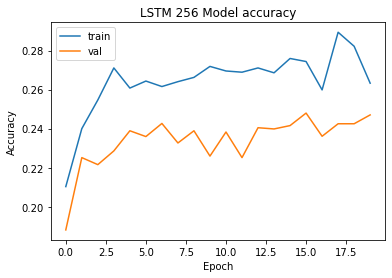

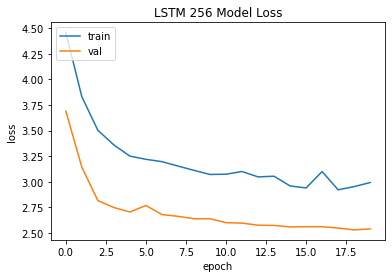

In [57]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('LSTM 256 Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM 256 Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [58]:
class CoattentionModel(tf.keras.layers.Layer):
    def __init__(self):#, num_embeddings, num_classes, embed_dim=512, k=30
        super().__init__()
        self.num_classes = len(ans_vocab)
        self.hidden_size = 512
        self.dropout = 0.5
        self.num_embeddings = len(ques_vocab)+1

        self.image_dense = tf.keras.layers.Dense(self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_normal(seed=15)) 
        self.image_corr = tf.keras.layers.Dense(self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_normal(seed=29))

        self.image_atten_dense = tf.keras.layers.Dense(self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=17)) 
        self.question_atten_dens = tf.keras.layers.Dense(self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=28))
        self.question_atten_dropout = tf.keras.layers.Dropout(self.dropout)
        self.image_atten_dropout = tf.keras.layers.Dropout(self.dropout)

        self.ques_atten = tf.keras.layers.Dense(1, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=21))

        self.img_atten = tf.keras.layers.Dense(1, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=33))

        self.embed = tf.keras.layers.Embedding(self.num_embeddings, self.hidden_size,
                                               embeddings_initializer = tf.keras.initializers.RandomNormal(mean=0, stddev=1, seed=23))
        
        self.unigram_conv = tf.keras.layers.Conv1D(filters = self.hidden_size, kernel_size = 1, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed=41))
        self.bigram_conv  = tf.keras.layers.Conv1D(filters = self.hidden_size, kernel_size = 2, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed=58), dilation_rate = 2)
        self.trigram_conv = tf.keras.layers.Conv1D(filters = self.hidden_size, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed=89), dilation_rate = 2)
        self.max_pool = tf.keras.layers.MaxPool2D((3,1))
        self.phrase_dropout = tf.keras.layers.Dropout(self.dropout)
        
        self.lstm = tf.keras.layers.LSTM(units = 512, return_sequences=True, dropout = self.dropout,
                                         kernel_initializer = tf.keras.initializers.glorot_uniform(seed=26),
                                         recurrent_initializer = tf.keras.initializers.orthogonal(seed=54))
        
        self.tanh = tf.keras.layers.Activation('tanh')
        self.softmax = tf.keras.layers.Activation('softmax')
        
        self.W_w_dropout = tf.keras.layers.Dropout(self.dropout)
        self.W_p_dropout = tf.keras.layers.Dropout(self.dropout)
        self.W_s_dropout = tf.keras.layers.Dropout(self.dropout)

        self.W_w = tf.keras.layers.Dense(units = self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=32), input_shape = (self.hidden_size,))
        self.W_p = tf.keras.layers.Dense(units = self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=49), input_shape = (2 * self.hidden_size, ))
        self.W_s = tf.keras.layers.Dense(units = self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=31), input_shape = (2 * self.hidden_size, ))
        
        self.fc1_Dense = tf.keras.layers.Dense(units = 2 * self.hidden_size, activation='relu',
                                               kernel_initializer = tf.keras.initializers.he_normal(seed=84))
        self.fc1_dropout = tf.keras.layers.Dropout(self.dropout)

        self.fc = tf.keras.layers.Dense(units = self.num_classes, activation='softmax',kernel_initializer = tf.keras.initializers.glorot_uniform(seed=91), input_shape = (self.hidden_size,))
        
        return

    def call(self, image, question):#Image: B x 196 x 512
        
        image = self.image_dense(image)
        image = self.tanh(image)

        words = self.embed(question)    # Words: B x L x 51

        unigrams =  tf.expand_dims(self.tanh(self.unigram_conv(words)), 1) # B x L x 512
        bigrams  =  tf.expand_dims(self.tanh(self.bigram_conv(words)), 1)  # B x L x 512
        trigrams =  tf.expand_dims(self.tanh(self.trigram_conv(words)), 1) # B x L x 512

        phrase = tf.squeeze(self.max_pool(tf.concat((unigrams, bigrams, trigrams), 1)), axis=1)  # B x L x 512
        phrase = self.tanh(phrase)
        phrase = self.phrase_dropout(phrase)
  
        hidden = None
        sentence = self.lstm(phrase)        # B x L x 512   

        #print(words.shape, phrase.shape, sentence.shape)
        v_word, q_word = self.co_attention(image, words)
        v_phrase, q_phrase = self.co_attention(image, phrase)
        v_sent, q_sent = self.co_attention(image, sentence)

        h_w = self.tanh(self.W_w(self.W_w_dropout(q_word + v_word)))
        h_p = self.tanh(self.W_p(self.W_p_dropout(tf.concat(((q_phrase + v_phrase), h_w), axis=1))))
        h_s = self.tanh(self.W_s(self.W_s_dropout(tf.concat(((q_sent + v_sent), h_p), axis=1))))

        fc1 = self.fc1_Dense(self.fc1_dropout(h_s))
        logits = self.fc(fc1)

        return logits

    def co_attention(self, img_feat, ques_feat):  # V : B x 512 x 196, Q : B x L x 512
        img_corr = self.image_corr(img_feat)

        weight_matrix = tf.keras.backend.batch_dot(ques_feat, img_corr, axes = (2, 2))
        weight_matrix = self.tanh(weight_matrix)

        ques_embed = self.image_atten_dense(ques_feat)
        img_embed = self.question_atten_dens(img_feat)

        transform_img = tf.keras.backend.batch_dot(weight_matrix, img_embed)

        ques_atten_sum = self.tanh(transform_img + ques_embed)
        ques_atten_sum = self.question_atten_dropout(ques_atten_sum)
        ques_atten = self.ques_atten(ques_atten_sum)
        ques_atten =  tf.keras.layers.Reshape((ques_atten.shape[1],))(ques_atten)
        ques_atten =  self.softmax(ques_atten)

        transform_ques = tf.keras.backend.batch_dot(weight_matrix, ques_embed, axes = (1, 1))
        img_atten_sum = self.tanh(transform_ques+img_embed)
        img_atten_sum = self.image_atten_dropout(img_atten_sum)
        img_atten = self.img_atten(img_atten_sum)
        img_atten = tf.keras.layers.Reshape((img_atten.shape[1],))(img_atten)
        img_atten = self.softmax(img_atten)

        ques_atten = tf.keras.layers.Reshape(( 1, ques_atten.shape[1]))(ques_atten)
        img_atten = tf.keras.layers.Reshape(( 1, img_atten.shape[1]))(img_atten)

        ques_atten_feat = tf.keras.backend.batch_dot(ques_atten,ques_feat)
        #print(ques_atten_feat)
        ques_atten_feat = tf.keras.layers.Reshape(( ques_atten_feat.shape[-1],))(ques_atten_feat)

        img_atten_feat =  tf.keras.backend.batch_dot(img_atten, img_feat)
        #print(img_atten_feat)
        img_atten_feat = tf.keras.layers.Reshape((img_atten_feat.shape[-1],))(img_atten_feat)

        return img_atten_feat, ques_atten_feat

In [59]:
def scheduler(epoch):
    if epoch < 10:
        return 0.0001
    else:
        return 0.0001 * tf.math.exp(0.1 * (10 - epoch))

In [60]:
def callBacksList():
    """
    returns list of callback's
    """
    filepath = "Models" + ModelName + "/optimum.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = filepath, monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'auto')
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2)
    early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 4, verbose = 1)
    scheduler_lr = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0 )

    #directory for tensorboard to save evnts
    log_dir= "Models" + "logs/fit/" + ModelName + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    os.makedirs(log_dir)

    #print("TensorBoard Folder for this Execution",log_dir)#creating TensorBoard call back,this will write all events to given folder
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 0)

    history = tf.keras.callbacks.History()
    callbacks_list = [scheduler_lr, early_stop, history, tensorboard_callback, checkpoint]
    return callbacks_list

In [61]:
def Build_CoattentionModel():
    image_input1 = tf.keras.layers.Input(shape = (14,14, 512))
    image_input = tf.keras.layers.Reshape((-1, 512))(image_input1)

    question_input = tf.keras.layers.Input(shape=(question_vector_train.shape[1],))

    output = CoattentionModel()(image_input, question_input)#num_embeddings = len(ques_vocab), num_classes = len(ans_vocab), embed_dim = 512

    model = tf.keras.models.Model(inputs = [image_input1, question_input], outputs = output)

    model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [62]:
model = Build_CoattentionModel()
l2_alpha = 0.001
ModelName = 'Coattention'
history = model.fit(dataset_train, epochs = 20, steps_per_epoch=100, validation_data=dataset_val,validation_steps=100)

Epoch 1/20
100/100 [==============================] - 406s 4s/step - loss: 4.5150 - accuracy: 0.1991 - val_loss: 4.2601 - val_accuracy: 0.1881
Epoch 2/20
100/100 [==============================] - 374s 4s/step - loss: 4.1656 - accuracy: 0.2192 - val_loss: 3.3560 - val_accuracy: 0.2747
Epoch 3/20
100/100 [==============================] - 377s 4s/step - loss: 3.6716 - accuracy: 0.2383 - val_loss: 3.0593 - val_accuracy: 0.2095
Epoch 4/20
100/100 [==============================] - 377s 4s/step - loss: 3.5880 - accuracy: 0.2459 - val_loss: 2.9150 - val_accuracy: 0.2147
Epoch 5/20
100/100 [==============================] - 381s 4s/step - loss: 3.4152 - accuracy: 0.2531 - val_loss: 2.8382 - val_accuracy: 0.2389
Epoch 6/20
100/100 [==============================] - 376s 4s/step - loss: 3.2719 - accuracy: 0.2617 - val_loss: 2.8132 - val_accuracy: 0.2375
Epoch 7/20
100/100 [==============================] - 379s 4s/step - loss: 3.2895 - accuracy: 0.2528 - val_loss: 2.7640 - val_accuracy: 0.2308

In [63]:
model.save('Models/coattention dropout 0.5.h5')

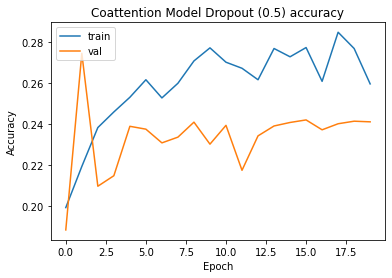

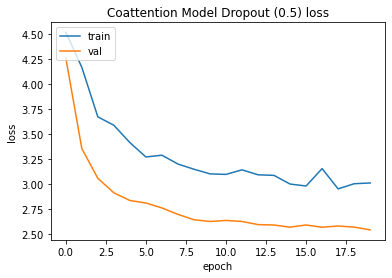

In [64]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Coattention Model Dropout (0.5) accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Coattention Model Dropout (0.5) loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

                                           Evaluation

In [47]:
model_1 = Build_CoattentionModel()
l2_alpha = 0.001
ModelName = 'Coattention'

(None, 24, 512) (None, 24, 512) (None, 24, 512)
Tensor("coattention_model_1/MatMul_3:0", shape=(None, 1, 512), dtype=float32)
Tensor("coattention_model_1/MatMul_4:0", shape=(None, 1, 512), dtype=float32)
Tensor("coattention_model_1/MatMul_8:0", shape=(None, 1, 512), dtype=float32)
Tensor("coattention_model_1/MatMul_9:0", shape=(None, 1, 512), dtype=float32)
Tensor("coattention_model_1/MatMul_13:0", shape=(None, 1, 512), dtype=float32)
Tensor("coattention_model_1/MatMul_14:0", shape=(None, 1, 512), dtype=float32)


In [49]:
model_1.load_weights('Models/coattention.h5')

ValueError: Cannot assign value to variable ' coattention_model_1/dense_21/kernel:0': Shape mismatch.The variable shape (1024, 13969), and the assigned value shape (1024, 1000) are incompatible.

In [95]:
answer_type = X_val['answer_type'].values 
answers = X_val['answers'].values 

In [96]:
question_type = X_val['question_type'].values

In [99]:
error_dict = {  _qtype : { 'top_1' : 0,'top_2' : 0,'top_3' : 0 ,'top_5' : 0,'count' : 0 } for _qtype in np.unique(question_type) }
actual_list = []
pred_list = []

In [ ]:
dataset_val = createDataset(image_paths_val, question_vector_val, answer_vector_val)

In [120]:
dataset_train

<PrefetchDataset shapes: ((<unknown>, <unknown>), (None, 1000)), types: ((tf.float32, tf.float32), tf.float32)>

In [106]:
for ((img_tensor, question), answer) in (dataset_val):
    y_pred = model_1.predict([img_tensor,question])

    for i in range(y_pred.shape[0]):
        _qtype = question_type[i].numpy().decode('utf-8')
        _atype = answer_type[i].numpy().decode('utf-8')
        error_dict[_qtype]['count'] += 1 
        
        for _k in [1]:#[1,2,3,5]:
            if _atype == 'yes/no' and _k > 1:
                top_k = tf.math.top_k(y_pred, k = 1 ).indices.numpy()[i]
            else:
                top_k = tf.math.top_k(y_pred, k = _k ).indices.numpy()[i]

            pred_classes = np.zeros(y_pred.shape[1])
            pred_classes[top_k] = 1
            actual_list.append(answers[i])
            pred_list.append(pred_classes)
            if np.dot(pred_classes,answer[i]) > 0:
                error_dict[_qtype]['top_' + str(_k)] += 1

0it [00:00, ?it/s]


ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
def model_metric(predictions, truths):
    total = 0
    correct_val=0.0
    for prediction, truth in (zip(predictions, truths)):
        truth = ast.literal_eval(truth.numpy().decode('utf-8'))#json.loads(truth.numpy().decode('utf-8').replace("\'", "\""))
        prediction = label_encoder.inverse_transform(np.array([prediction]))[0]
        temp_count=0
        total +=1
    for _truth in truth:
        if prediction == _truth['answer']:
            temp_count+=1
    # accuracy = min((# humans that provided that answer/3) , 1)
    if temp_count>2:
        correct_val+=1
    else:
        correct_val+=float(temp_count)/3
    return (correct_val/total)*100

model_metric(pred_list,actual_list)

In [ ]:
df_EA  = pd.DataFrame(error_dict).T
df_EA["Question_Type"] = df_EA.index
df_EA['Accuracy'] = df_EA['top_1']/df_EA['count'] * 100

df_EA = df_EA.sort_values('Accuracy',ascending=False)

ax = df_EA[['Question_Type','Accuracy']].plot.bar(stacked=False, figsize=(18,5), color='orange')
plt.title('Question Type vs Accuract on Test Data')
plt.show(

                                                                        Baseline Models tuning

In [73]:
model_name = "uncased_L-12_H-768_A-12"
model_dir = bert.fetch_google_bert_model(model_name, ".models")

AttributeError: module 'bert' has no attribute 'fetch_google_bert_model'

In [72]:
import bert

In [65]:
def callBacksList():
    """
    returns list of callback's
    """
    filepath = "Models" + ModelName + "baseline.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = filepath, monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'auto')
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', patience = 3)
    early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 4, verbose = 1)

    #directory for tensorboard to save evnts
    log_dir= "Models" + "logs/fit/" + ModelName + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    os.makedirs(log_dir)

    print("TensorBoard Folder for this Execution",log_dir)#creating TensorBoard call back,this will write all events to given folder
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)

    history = tf.keras.callbacks.History()
    callbacks_list = [reduce_lr, early_stop, history, tensorboard_callback, checkpoint]
    return callbacks_list

def Build_BaseModel():
    image_input = tf.keras.layers.Input(shape=(14,14,512))
    question_input = tf.keras.layers.Input(shape=(question_vector_train.shape[1],))

    image_conv_layer1 = tf.keras.layers.Conv2D(filters = 4096, kernel_size = 7 , strides = 1, padding = "valid", activation = 'relu',
                                               kernel_initializer = tf.keras.initializers.he_normal(seed=45))(image_input)

    image_flatten = tf.keras.layers.Flatten()(image_conv_layer1)

    image_dense_1 = tf.keras.layers.Dense(4096, activation = tf.nn.relu, 
                                          kernel_initializer = tf.keras.initializers.he_uniform(seed=54))(image_flatten)
    
    image_dense_2 = tf.keras.layers.Dense(1024, activation = tf.nn.relu, 
                                          kernel_initializer = tf.keras.initializers.he_uniform(seed=32))(image_dense_1)


    # Input 2 Pathway
    question_emb = tf.keras.layers.Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 300 ,name = "Embedding_Layer",
                                             embeddings_initializer = tf.keras.initializers.RandomNormal(mean=0, stddev=1, seed=23))(question_input)

    question_lstm = tf.keras.layers.LSTM(1024, 
                                         kernel_initializer = tf.keras.initializers.glorot_uniform(seed=26),
                                         recurrent_initializer = tf.keras.initializers.orthogonal(seed=54),
                                         bias_initializer=tf.keras.initializers.zeros())(question_emb)

    question_flatten = tf.keras.layers.Flatten(name="Flatten_lstm")(question_lstm)

    
    image_question = tf.keras.layers.Multiply()([image_dense_2, question_flatten])


    image_question_dense_1 = tf.keras.layers.Dense(1000, activation = tf.nn.relu,
                                                    kernel_initializer = tf.keras.initializers.he_uniform(seed=19))(image_question)
    
    image_question_dense_2 = tf.keras.layers.Dense(1000, activation = tf.nn.relu, 
                                                   kernel_initializer = tf.keras.initializers.he_uniform(seed=28))(image_question_dense_1)

    output = tf.keras.layers.Dense(len(ans_vocab), activation=tf.nn.softmax, 
                                   kernel_initializer = tf.keras.initializers.glorot_normal(seed=15))(image_question_dense_2)

    # Create Model
    model = tf.keras.models.Model(inputs = [image_input, question_input], outputs = output)
    # Compile
    model.compile(optimizer = 'tf.keras.optimizers.SGD()', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [ ]:
l2_alpha = 0.001
ModelName ="BaselineModel"
model = Build_BaseModel()

In [ ]:
history = model.fit(dataset_train, epochs = 20, steps_per_epoch=100, validation_data=dataset_val,validation_steps=100)

In [ ]:
model.save('Models/baseline_sgd.h5')

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Baseline SGD')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Baseline SGD')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
def callBacksList():
    """
    returns list of callback's
    """
    filepath = "Models" + ModelName + "bert.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = filepath, monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'auto')
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', patience = 3)
    early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 4, verbose = 1)

    #directory for tensorboard to save evnts
    log_dir= "Models" + "logs/fit/" + ModelName + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    os.makedirs(log_dir)

    print("TensorBoard Folder for this Execution",log_dir)#creating TensorBoard call back,this will write all events to given folder
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)

    history = tf.keras.callbacks.History()
    callbacks_list = [reduce_lr, early_stop, history, tensorboard_callback, checkpoint]
    return callbacks_list

In [ ]:
def Build_BertModel():
    l_bert.trainable = False
    
    image_input = tf.keras.layers.Input(shape=(14,14, 512))
    question_input = tf.keras.layers.Input(shape=(question_vector_train.shape[1],))

    image_flatten = tf.keras.layers.Flatten()(question_input)

    # Input 2 Pathway
    question_emb = l_bert(question_input)

    question_flatten = tf.keras.layers.Flatten(name="Flatten_lstm")(question_emb)

    image_question = tf.keras.layers.concatenate([image_flatten, question_flatten])

    bn = tf.keras.layers.BatchNormalization()(image_question)
    dropout = tf.keras.layers.Dropout(0.5)(bn)
    
    output = tf.keras.layers.Dense(len(ans_vocab), activation='softmax', 
                                   kernel_initializer = tf.keras.initializers.he_normal(seed=42))(dropout)

    # Create Model
    model = tf.keras.models.Model(inputs = [image_input, question_input], outputs = output)
    
    return model


In [ ]:
l2_alpha = 0.001
ModelName ="BaselineModel"
model = Build_BertModel()
history = model.fit(dataset_train, epochs = 20, steps_per_epoch=100, validation_data=dataset_val,validation_steps=100)